In [1]:
!wget "https://service.archief.nl/gaf/api/file/v1/render/e3667804-f3b8-4336-ae53-a1b42b6fa731" -O image.jpeg

--2025-04-01 04:06:25--  https://service.archief.nl/gaf/api/file/v1/render/e3667804-f3b8-4336-ae53-a1b42b6fa731
Resolving service.archief.nl (service.archief.nl)... 195.169.53.74, 2001:610:1e0::2:adf:ff4a
Connecting to service.archief.nl (service.archief.nl)|195.169.53.74|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [image/jpeg]
Saving to: ‘image.jpeg’

image.jpeg              [    <=>             ]   1.16M  1.09MB/s    in 1.1s    

2025-04-01 04:06:27 (1.09 MB/s) - ‘image.jpeg’ saved [1219191]



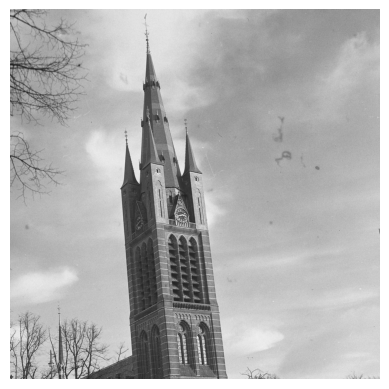

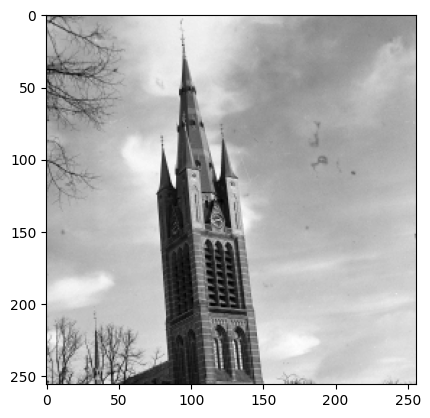

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read image and convert to grayscale
img = cv2.imread('image.jpeg', cv2.IMREAD_GRAYSCALE)

# Define cropping coordinates
x, y, w, h = 700, 220, 2048, 2048
img = img[y:y+h, x:x+w]

# Show cropped image
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.show()

# Resize image to 256x256
img = cv2.resize(img, (256, 256), interpolation=cv2.INTER_AREA)

# Show resized image
plt.imshow(img, cmap='gray')
plt.show()

original_img = img.copy()

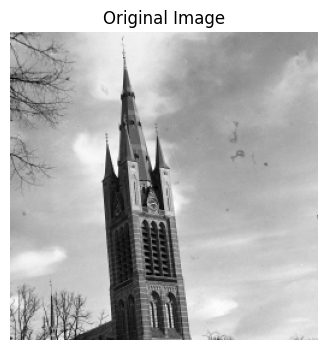

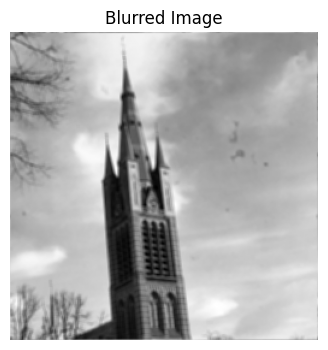

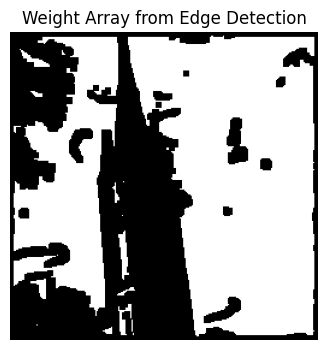

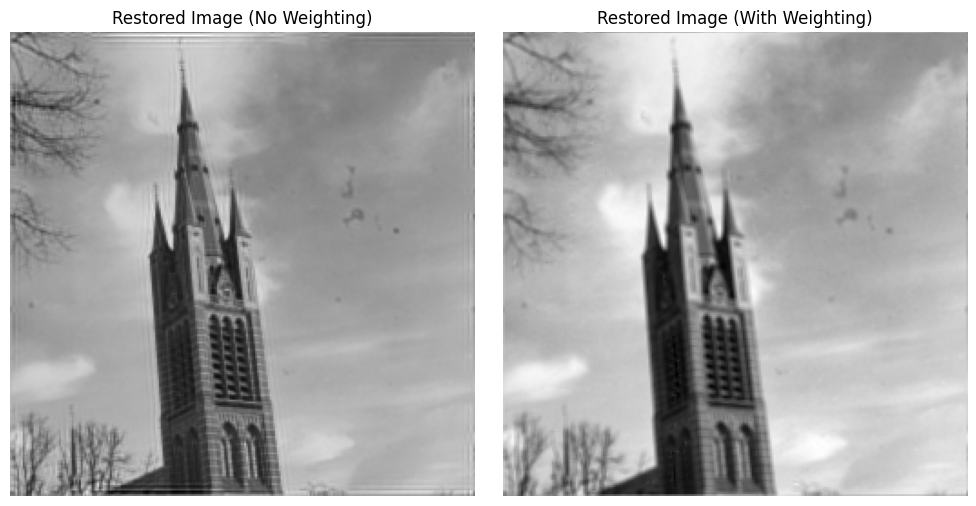

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

# -------------------------------
# 1. Create a synthetic test image.
# -------------------------------
def create_test_image(N=256):
    # Create a 256x256 image with a white square in the center
    image = np.zeros((N, N), dtype=float)
    # Draw a square with intensity 1 in the center
    start = N // 4
    end = 3 * N // 4
    image[start:end, start:end] = 1.0
    return image

# -------------------------------
# 2. Build a Gaussian filter (PSF) manually.
# -------------------------------
def gaussian_kernel(size, sigma):
    """
    Create a square Gaussian kernel of given 'size' and standard deviation 'sigma'
    """
    # Create a coordinate grid, centered at zero.
    ax = np.linspace(-(size-1)/2, (size-1)/2, size)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-0.5 * (xx**2 + yy**2) / sigma**2)
    kernel /= np.sum(kernel)
    return kernel

# -------------------------------
# 3. Simulate blur by convolving the image with the PSF.
# -------------------------------
def simulate_blur(image, psf):
    # Use convolve2d with 'same' mode and 'symm' boundary conditions.
    blurred = convolve2d(image, psf, mode='same', boundary='symm')
    return blurred

# -------------------------------
# 4a. Implement a simple Sobel edge detector.
# -------------------------------
def sobel_edge(image):
    # Define Sobel kernels (for horizontal and vertical gradients)
    Kx = np.array([[-1, 0, 1],
                   [-2, 0, 2],
                   [-1, 0, 1]], dtype=float)
    Ky = np.array([[-1, -2, -1],
                   [ 0, 0, 0],
                   [ 1, 2, 1]], dtype=float)
    # Convolve image with each kernel.
    Gx = convolve2d(image, Kx, mode='same', boundary='symm')
    Gy = convolve2d(image, Ky, mode='same', boundary='symm')
    # Edge magnitude
    G = np.hypot(Gx, Gy)
    # Normalize to range [0,1]
    G = G / (np.max(G) + 1e-8)
    return G

# -------------------------------
# 4b. Implement a simple dilation (maximum filter) function.
# -------------------------------
def dilation(image, window_size=5):
    """
    A basic dilation: for each pixel, take the maximum value in a (window_size x window_size) neighborhood.
    """
    pad = window_size // 2
    padded = np.pad(image, pad_width=pad, mode='edge')
    dilated = np.zeros_like(image)
    N, M = image.shape
    # Loop over each pixel (for clarity; for speed vectorized implementations exist)
    for i in range(N):
        for j in range(M):
            window = padded[i:i+window_size, j:j+window_size]
            dilated[i, j] = np.max(window)
    return dilated

# -------------------------------
# 5. Richardson-Lucy deconvolution with optional weighting.
# -------------------------------
def rl_deconvolution(blurred, init_psf, num_iter=30, weight=None):
    """
    Perform deconvolution using a Richardson-Lucy iteration.
    For simplicity, the PSF is kept fixed (i.e. non-blind deconvolution).
    Optionally, a weight array (same shape as the image) can modulate the update.
    """
    J = blurred.copy() # initial guess for the latent image
    P = init_psf.copy()
    # Precompute the flipped PSF (mirror in both directions)
    P_mirror = np.flipud(np.fliplr(P))

    for it in range(num_iter):
        # Convolve current estimate with PSF.
        conv_J_P = convolve2d(J, P, mode='same', boundary='symm')
        # Avoid division by zero.
        relative_blur = blurred / (conv_J_P + 1e-8)
        # Convolve with flipped PSF.
        correction = convolve2d(relative_blur, P_mirror, mode='same', boundary='symm')
        if weight is not None:
            # Use the weight array to modulate the correction:
            correction = weight * correction + (1 - weight)
        # Update the estimate.
        J *= correction
        # Enforce non-negativity.
        J[J < 0] = 0
    return J, P

# -------------------------------
# Main demonstration function.
# -------------------------------
def main():
    # image.
    # I = create_test_image(N=256)

    x = img.copy()

    plt.figure(figsize=(4,4))
    plt.imshow(x, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')
    plt.show()

    # Generate a Gaussian PSF (3x3, sigma=5)
    sigma = 5
    k = np.array([
      [np.exp(-((1**2 + 1**2) / (2 * sigma**2))), np.exp(-((0**2 + 1**2) / (2 * sigma**2))), np.exp(-((1**2 + 1**2) / (2 * sigma**2)))],
      [np.exp(-((1**2 + 0**2) / (2 * sigma**2))), np.exp(-((0**2 + 0**2) / (2 * sigma**2))), np.exp(-((1**2 + 0**2) / (2 * sigma**2)))],
      [np.exp(-((1**2 + 1**2) / (2 * sigma**2))), np.exp(-((0**2 + 1**2) / (2 * sigma**2))), np.exp(-((1**2 + 1**2) / (2 * sigma**2)))]
      ]) / (2 * np.pi * sigma**2)
    k /= k.sum()
    # psf_true = gaussian_kernel(size=7, sigma=10)

    # Blur the image
    y = convolve2d(x, k, mode='same', boundary='wrap')

    # Simulate the blur.
    # Blurred = simulate_blur(I, psf_true)
    plt.figure(figsize=(4,4))
    plt.imshow(y, cmap='gray')
    plt.title("Blurred Image")
    plt.axis('off')
    plt.show()

    # For this demo, we assume the true PSF is unknown.
    # We use an initial guess for the PSF. For simplicity, we take it equal to psf_true.
    init_psf = k.copy() # In practice, different initializations (undersized/oversized) can be tried.

    # Optionally, compute a weight array from edges.
    # Compute edges using our simple Sobel operator.
    edges = sobel_edge(y)
    # Threshold the edge magnitude.
    edge_thresh = 0.08
    binary_edges = (edges > edge_thresh).astype(float)
    # Dilate the edge map using our simple dilation.
    dilated_edges = dilation(binary_edges, window_size=5)
    # Define the weight array: for example, weight = 1 - (dilated edge map).
    weight = 1.0 - dilated_edges
    # Zero out the borders (first 3 and last 3 rows/columns).
    weight[:3, :] = 0
    weight[-3:, :] = 0
    weight[:, :3] = 0
    weight[:, -3:] = 0

    plt.figure(figsize=(4,4))
    plt.imshow(weight, cmap='gray')
    plt.title("Weight Array from Edge Detection")
    plt.axis('off')
    plt.show()

    # Perform deconvolution without weighting.
    J_unreg, _ = rl_deconvolution(y, init_psf, num_iter=30, weight=None)
    # Perform deconvolution with weighting.
    J_reg, _ = rl_deconvolution(y, init_psf, num_iter=30, weight=weight)

    # Plot the restored images.
    fig, axes = plt.subplots(1,2, figsize=(10,5))
    axes[0].imshow(J_unreg, cmap='gray')
    axes[0].set_title("Restored Image (No Weighting)")
    axes[0].axis('off')
    axes[1].imshow(J_reg, cmap='gray')
    axes[1].set_title("Restored Image (With Weighting)")
    axes[1].axis('off')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()